# Analysis of the 2nd 2024 Barometer of Catalonia (pt4)
# Supervised Learning: Predicting clusters using demographical variables.

In this Jupyter Notebook, I aim to predict an individual's political group based on various demographic variables using supervised learning techniques. The underlying assumption is that political ideology is strongly influenced by one's material conditions, and therefore, demographic patterns should allow for accurate classification into ideological clusters.

In [1]:
import pandas as pd
import numpy as np
import pandasql as psql
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import shap

We load the dataset with the cluster and the metadata refering to the variable types

In [2]:
df1 = pd.read_excel('df_clusteritzat.xlsx')
var_an = pd.read_excel('Variables_analisi.xlsx')

We get the dataset with the predictive demographic variables and the response variable ```Cluster``` which is the political opinion group created in the previous program

In [3]:
var_demo = var_an[var_an["Grup"]=='d']["Variables"]
var_demo = list( var_demo )
var_demo.append("Cluster")

df2 = df1[var_demo]
df2.head()

,PROVINCIA,MUNICIPI,COMARCA,CIUTADANIA,SEXE,EDAT,LLOC_NAIX,INF_POL_DIARI_FREQ,INF_POL_TV_FREQ,INF_POL_RADIO_FREQ,...,SIT_LAB,ESTUDIS_1_15,ESTAT_CIVIL_2,LLENGUA_PRIMERA_1_3,LLENGUA_IDENT_1_3,CLASSE_SOCIAL_SUBJECTIVA_1_7,PERSONES_LLAR,ORIENTACIO_SEXUAL,INGRESSOS_1_15,Cluster
0,Barcelona,Barcelona (ciutat),Barcelonès,"Sí, tinc la ciutadania (espanyola)",Femení,19,Catalunya,1-2 dies per setmana,Mai,Mai,...,No treballa,"Educació secundaria (ESO, EGB, Graduat Escolar...",Solter/a,Altres opcions,Català,Classe treballadora mitjana,3.0,Heterosexual (parella d’un home i una dona),De 3.001 a 4.000 €,0
1,Barcelona,Barcelona (ciutat),Barcelonès,"Sí, tinc la ciutadania (espanyola)",Masculí,59,Catalunya,Tots els dies,Mai,Tots els dies,...,Treballa,Arquitectura/Enginyeria Tècnica (Aparellador/a...,Casat/ada,Castellà,Català,Classe mitjana baixa,2.0,Heterosexual (parella d’un home i una dona),De 2.401 a 3.000 €,0
2,Barcelona,Barcelona (ciutat),Barcelonès,"Sí, tinc la ciutadania (espanyola)",Masculí,68,Catalunya,Amb menys freqüència,Tots els dies,Amb menys freqüència,...,No treballa,"Diplomatura (Només diplomatures oficials, no c...",Casat/ada,Català,Català,Classe treballadora mitjana,2.0,Heterosexual (parella d’un home i una dona),De 2.401 a 3.000 €,1
3,Barcelona,Barcelona (ciutat),Barcelonès,"Sí, tinc la ciutadania (espanyola)",Femení,51,Altres comunitats autònomes,Tots els dies,Tots els dies,1-2 dies per setmana,...,Treballa,FP de Grau Superior (Cicle/mòdul formatiu de F...,Solter/a,Castellà,Castellà,Classe treballadora alta,1.0,Heterosexual (parella d’un home i una dona),De 2.001 a 2.400 €,0
4,Barcelona,Barcelona (ciutat),Barcelonès,"Sí, tinc la ciutadania (espanyola)",Femení,70,Catalunya,Tots els dies,5-6 dies per setmana,Tots els dies,...,No treballa,Llicenciatura (Titulacions amb equivalència of...,Casat/ada,Català,Català,Classe mitjana,2.0,Heterosexual (parella d’un home i una dona),No contesta,0


In [4]:
df2.columns

Index(['PROVINCIA', 'MUNICIPI', 'COMARCA', 'CIUTADANIA', 'SEXE', 'EDAT',
       'LLOC_NAIX', 'INF_POL_DIARI_FREQ', 'INF_POL_TV_FREQ',
       'INF_POL_RADIO_FREQ', 'INF_POL_XARXES_FREQ', 'INF_POL_PREMSA_DIARI',
       'INF_POL_XARXES', 'INF_POL_RADIO_EMISSORA', 'INF_POL_TV_CANAL',
       'VACANCES', 'RELIGIO', 'SIT_LAB', 'ESTUDIS_1_15', 'ESTAT_CIVIL_2',
       'LLENGUA_PRIMERA_1_3', 'LLENGUA_IDENT_1_3',
       'CLASSE_SOCIAL_SUBJECTIVA_1_7', 'PERSONES_LLAR', 'ORIENTACIO_SEXUAL',
       'INGRESSOS_1_15', 'Cluster'],
      dtype='object')

## 01. Seeking correlations 

But first of all I want to explore the data in order to find variables with predictive power to classify the individual. 

First of all, I want to explore the data to identify variables with predictive power for classifying individuals. After examining the two numerical variables in the dataset, I observed that the age distribution is similar across both clusters. However, individuals in the second cluster tend to live with more people in their households compared to those in the first cluster. This could suggest that individuals in the second cluster either have lower income or live with their families in a more traditional way

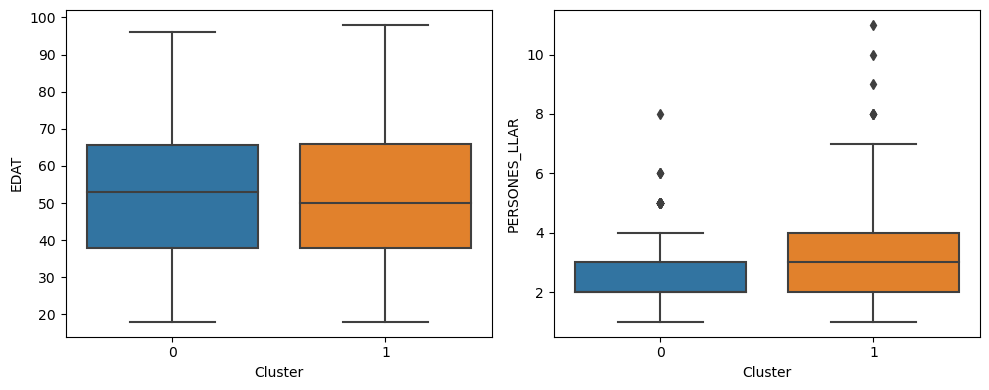

In [5]:
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)  # 2 rows, 2 columns, plot 1
sns.boxplot(x=df2["Cluster"],y=df2["EDAT"])

plt.subplot(1, 2, 2)  # 2 rows, 2 columns, plot 1
sns.boxplot(x=df2["Cluster"],y=df2["PERSONES_LLAR"])

plt.tight_layout()

plt.show()

I create a function to create a barplot of a categorical variable grouping by the cluster

In [6]:
def barplot2(variable):
    # Calcular el nombre de les observacions per a cada combinació de 'variable' i 'Cluster'
    counts = df2.groupby([variable, 'Cluster']).size().reset_index(name='Count')
    # Calcular el total per a cada 'Cluster'
    total_counts = counts.groupby('Cluster')['Count'].transform('sum')
    # Convertir el nombre en percentatge
    counts['Percentage'] = (counts['Count'] / total_counts) * 100
    # Crear el gràfic de barres amb percentatges
    sns.barplot(data=counts, x='Cluster', y='Percentage', hue=variable)

One cluster predominantly identifies with Catalan as both their identity and first language, while the other cluster identifies more with Spanish. The main TV channel for the first cluster is TV3, whereas the second cluster shows more variability in their preferred channels. The first cluster is also less religious, with fewer identifying as Catholic compared to the second cluster. Additionally, most individuals in the first cluster were born in Catalonia, while the second cluster includes more people born in other parts of Spain or abroad.

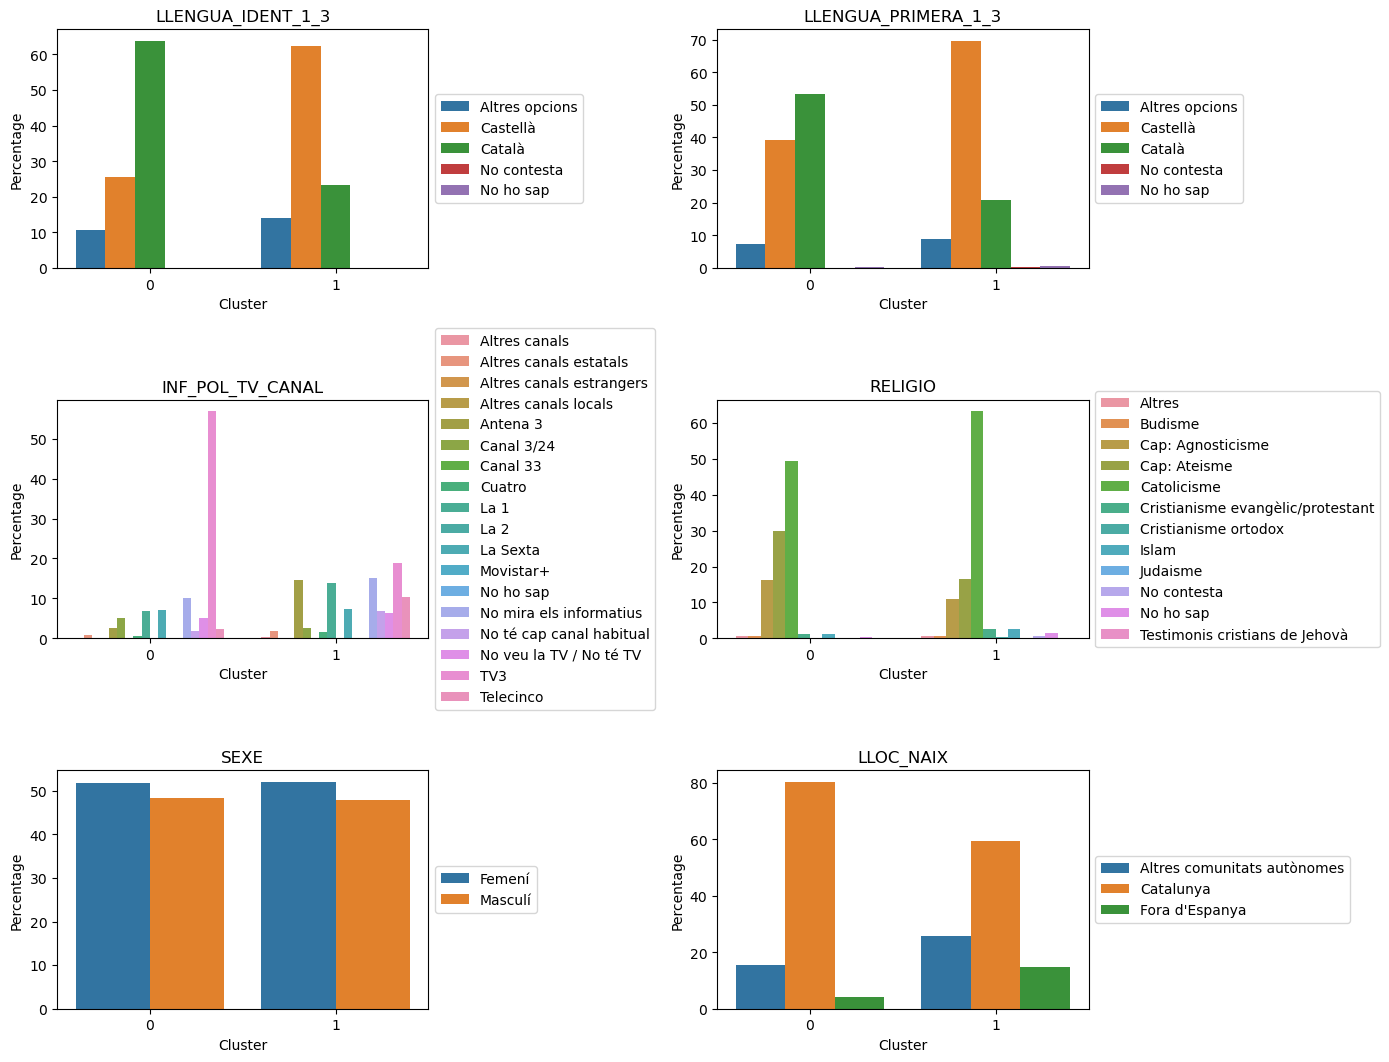

In [7]:
plt.figure(figsize=(14,14))

i = 0
for var in ["LLENGUA_IDENT_1_3", "LLENGUA_PRIMERA_1_3", "INF_POL_TV_CANAL", "RELIGIO", "SEXE", "LLOC_NAIX"]:
    i += 1
    ax = plt.subplot(4, 2, i)
    barplot2(var)
    plt.title(var)
    # Col·loca la llegenda fora del gràfic, a la dreta
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

## ML Models: Predicting the opinion cluster

### Preparing the data

Let's prepare do a One Hot Encoding at cathegorical variables codifying each category of the variable with a binary 1/0.

In [8]:
df2_OHE = pd.get_dummies(df2, columns = df2.dtypes[df2.dtypes=="object"].index, drop_first=True, dtype=int)
df2_OHE

,EDAT,PERSONES_LLAR,Cluster,PROVINCIA_Girona,PROVINCIA_Lleida,PROVINCIA_Tarragona,MUNICIPI_Argentona,MUNICIPI_Badalona,MUNICIPI_Banyoles,MUNICIPI_Barberà del Vallès,...,INGRESSOS_1_15_De 4.001 a 4.500 €,INGRESSOS_1_15_De 4.501 a 5.000 €,INGRESSOS_1_15_De 5.001 a 6.000 €,INGRESSOS_1_15_De 601 a 900 €,INGRESSOS_1_15_De 901 a 1000 €,INGRESSOS_1_15_Menys o igual a 300 €,INGRESSOS_1_15_Més de 6.000 €,INGRESSOS_1_15_No contesta,INGRESSOS_1_15_No ho sap,INGRESSOS_1_15_No tè cap tipus d'ingrés
0,19,3.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,59,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,68,2.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,51,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,70,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,49,4.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1996,39,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,39,4.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,69,4.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Let's get the predictor variables ```X``` and outcome ```y```.

In [9]:
X = df2_OHE.drop(columns=["Cluster"])
y = df2_OHE["Cluster"]

I get the train set for training the models and the test for checking the performance of the models.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

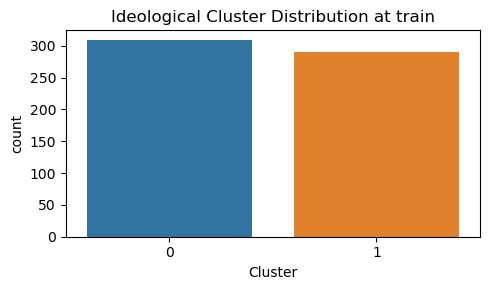

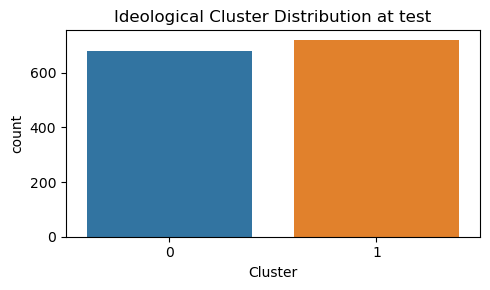

In [11]:
plt.figure(figsize=(5,3))
sns.barplot(
    x=y_test.value_counts().index,
    y=y_test.value_counts()
)
plt.title("Ideological Cluster Distribution at train")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
sns.barplot(
    x=y_train.value_counts().index,
    y=y_train.value_counts()
)
plt.title("Ideological Cluster Distribution at test")
plt.tight_layout()
plt.show()

### Random Forest

Let's try a RandomForest!

In [12]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train,y_train)
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)

The performance of the model is good. The model is able to identify individuals of both clusters, having a small False Positive and False Negative rate. The accuracy of the model is around 76$\%$ which is good.

In [13]:
print( classification_report(y_test,y_pred_rf) )
print("Accuracy:", accuracy_score(y_test,y_pred_rf) )

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       309
           1       0.76      0.73      0.74       291

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.76       600
weighted avg       0.76      0.76      0.76       600

Accuracy: 0.7583333333333333


Let's see the confusion matrix so I can see the real cluster and the predicted cluster.

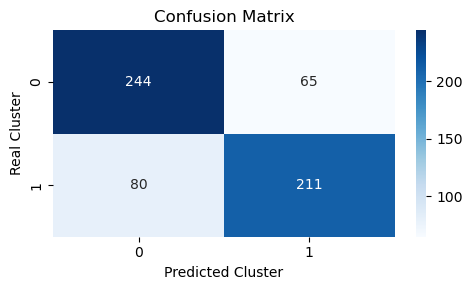

In [14]:
cm_rf = confusion_matrix(y_test,y_pred_rf)

plt.figure(figsize=(5,3))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Cluster')
plt.ylabel('Real Cluster')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

The ROC Curve and his Area Under the Curve is shown. Again the performance of the model is good, having a nice AUC.

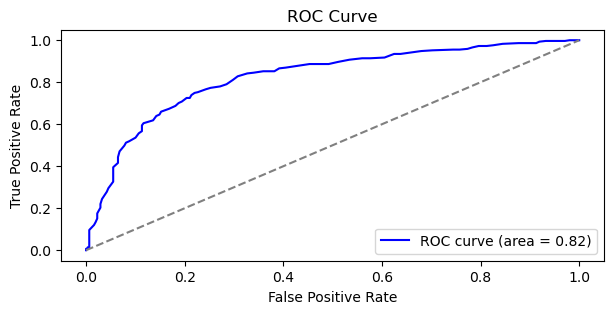

In [15]:
fpr, tpr, thresholds = roc_curve(y_test,y_prob_rf[:, 1])

plt.figure(figsize=(7, 3))
plt.plot(fpr, tpr, color='b', label='ROC curve (area = {:.2f})'.format(roc_auc_score(y_test,y_prob_rf[:, 1])))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

When interpreting the variable importance from the Random Forest model, it becomes clear that language use—specifically, the use of Catalan and Spanish—is highly relevant in identifying an individual's political ideology. Individuals who primarily speak Catalan are more likely to belong to the pro-independence cluster, whereas those who predominantly speak Spanish tend to be associated with the unionist cluster.

In addition, media consumption plays a significant role. For instance, individuals who regularly watch TV3 are much more likely to lean towards pro-independence views.

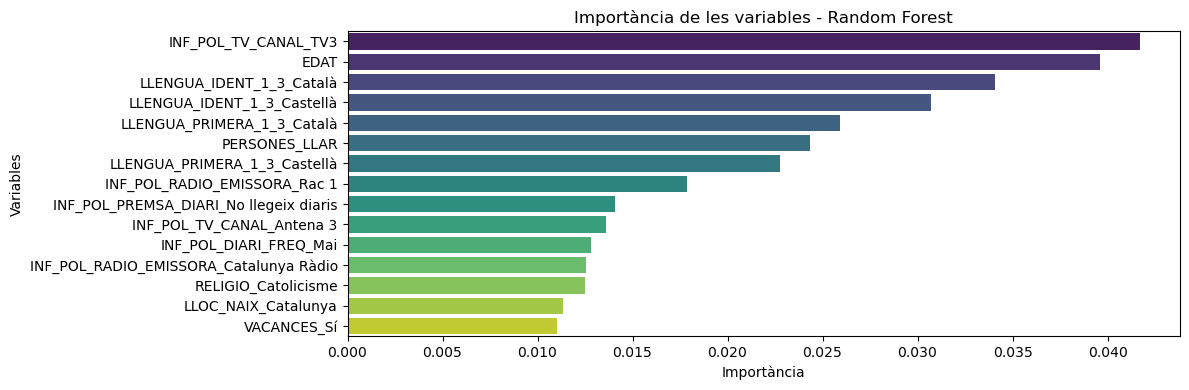

In [16]:
importances = rf_clf.feature_importances_
feature_names = X_train.columns

# Ordenar per importància
indices = np.argsort(importances)[::-1]  # De més a menys important
sorted_importances = importances[indices]
sorted_features = [feature_names[i] for i in indices]

# Crear el gràfic
plt.figure(figsize=(12, 4))
sns.barplot(x=sorted_importances[:15], y=sorted_features[:15], palette="viridis")  # Top 15 variables
plt.xlabel("Importància")
plt.ylabel("Variables")
plt.title("Importància de les variables - Random Forest")

plt.tight_layout()

plt.show()

### Gradient Boosting

Let's try a boosting model, specifically the one from ```xgboost``` library.

In [17]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, max_depth=2, random_state=1111)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
y_prob_xgb = xgb_clf.predict_proba(X_test)

The performance of the XGBoost is very similar with the Random Forest. However the XGBoost predicts a little better the individuals from the second cluster and worst the ones from the first cluster.

In [18]:
print( classification_report(y_test,y_pred_xgb) )

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       309
           1       0.76      0.76      0.76       291

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.77      0.77      0.77       600



Again, the model does a good job identifiying individuals for both clusters 1 and 2.

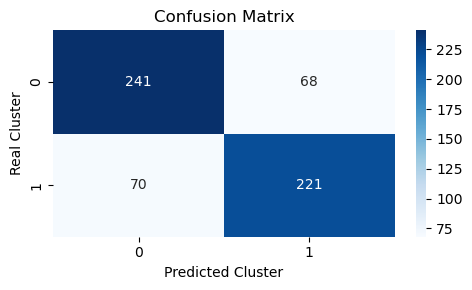

In [19]:
cm_xgb = confusion_matrix(y_test,y_pred_xgb)

plt.figure(figsize=(5,3))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Cluster')
plt.ylabel('Real Cluster')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

The ROC Curve and his Area Under the Curve is shown. Is slightly higher than in the Random Forest model.

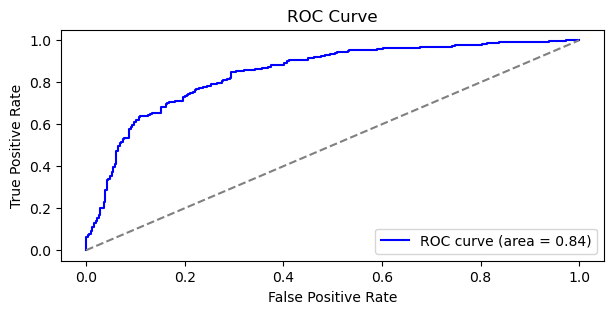

In [20]:
fpr, tpr, thresholds = roc_curve(y_test,y_prob_xgb[:, 1])

plt.figure(figsize=(7, 3))
plt.plot(fpr, tpr, color='b', label='ROC curve (area = {:.2f})'.format(roc_auc_score(y_test,y_prob_xgb[:, 1])))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Let's check the SHAP values of the XGBoost model. Once again, the most relevant variables used by the model to classify individuals are Catalan or Spanish language use, and media consumption—specifically the TV channel TV3 and the radio station Catalunya Ràdio. Once again, linguistic practices and media preferences are highly relevant when it comes to identifying an individual's ideological tendencies.

C:\Users\Pol\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


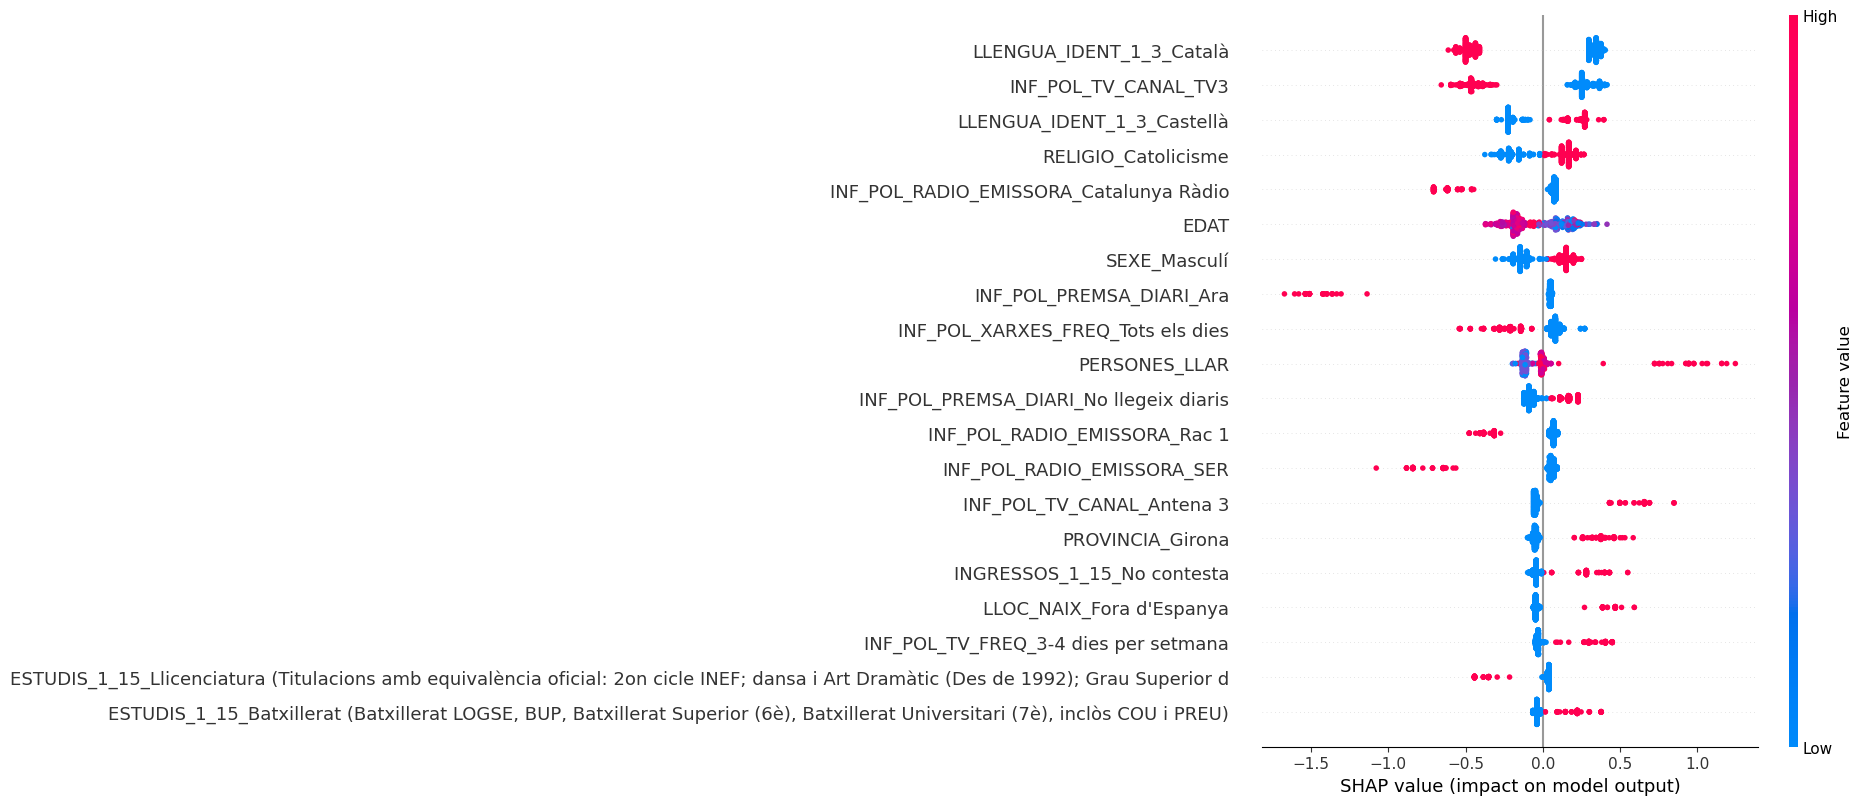

In [21]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)